## Assignment: Image recognition
- Alumno 1:
- Alumno 2:
- Alumno 3:

The goals of the assignment are:
* Develop proficiency in using Tensorflow/Keras for training Neural Nets (NNs).
* Put into practice the acquired knowledge to optimize the parameters and architecture of a feedforward Neural Net (ffNN), in the context of an image recognition problem.
* Put into practice NNs specially conceived for analysing images. Design and optimize the parameters of a Convolutional Neural Net (CNN) to deal with previous task.
* Train popular architectures from scratch (e.g., GoogLeNet, VGG, ResNet, ...), and compare the results with the ones provided by their pre-trained versions using transfer learning.

Follow the link below to download the classification data set  “xview_recognition”: [https://drive.upm.es/s/4oNHlRFEd71HXp4](https://drive.upm.es/s/4oNHlRFEd71HXp4)

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
!unzip "/content/gdrive/MyDrive/xview_recognition.zip"

Output streaming troncato alle ultime 5000 righe.
  inflating: xview_train/Shipping container/7535dd1d-92f1-4007-8264-a6750c99a899.tif  
  inflating: xview_train/Shipping container/199e85aa-99c7-470b-9066-073634f2e02c.tif  
  inflating: xview_train/Shipping container/a4d2949f-f9f3-4fd3-ace0-4af8400bfd4a.tif  
  inflating: xview_train/Shipping container/44430654-4ec0-4f66-b6fa-86448807b011.tif  
  inflating: xview_train/Shipping container/ce8e443f-b915-486e-af5c-13e5f2ebb9f1.tif  
  inflating: xview_train/Shipping container/1ae7c2a0-63ee-46d4-acaa-b86d3af581b8.tif  
  inflating: xview_train/Shipping container/6efd49ec-7789-483c-93d5-90fe2d5098b0.tif  
  inflating: xview_train/Shipping container/cf285f00-3242-4259-895b-2da7282c0aaa.tif  
  inflating: xview_train/Shipping container/6d96f2ec-ed73-4639-abe7-53485b52db05.tif  
  inflating: xview_train/Shipping container/c7fc8511-d3a7-4ae9-bc6d-4d5ce506cb9c.tif  
  inflating: xview_train/Shipping container/9e020010-9a53-4911-9991-52b837dd0e2a

In [ ]:
import uuid
import numpy as np

class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category= -1
        self.score = -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)

In [ ]:
categories = {0: 'Cargo plane', 1: 'Helicopter', 2: 'Small car', 3: 'Bus', 4: 'Truck', 5: 'Motorboat', 6: 'Fishing vessel', 7: 'Dump truck', 8: 'Excavator', 9: 'Building', 10: 'Storage tank', 11: 'Shipping container'}

In [ ]:
pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 42.8 MB/s eta 0:00:00


In [ ]:
import warnings
import rasterio
import numpy as np

def load_geoimage(filename):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    src_raster = rasterio.open(filename, 'r')
    # RasterIO to OpenCV (see inconsistencies between libjpeg and libjpeg-turbo)
    input_type = src_raster.profile['dtype']
    input_channels = src_raster.count
    img = np.zeros((src_raster.height, src_raster.width, src_raster.count), dtype=input_type)
    for band in range(input_channels):
        img[:, :, band] = src_raster.read(band+1)
    return img

def generator_images(objs, batch_size, do_shuffle=False):
    while True:
        if do_shuffle:
            np.random.shuffle(objs)
        groups = [objs[i:i+batch_size] for i in range(0, len(objs), batch_size)]
        for group in groups:
            images, labels = [], []
            for (filename, obj) in group:
                # Load image
                images.append(load_geoimage(filename))
                probabilities = np.zeros(len(categories))
                probabilities[list(categories.values()).index(obj.category)] = 1
                labels.append(probabilities)
            images = np.array(images).astype(np.float32)
            labels = np.array(labels).astype(np.float32)
            yield images, labels

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def draw_confusion_matrix(cm, categories):
    # Draw confusion matrix
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=list(categories.values()), yticklabels=list(categories.values()), ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(20-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show(fig)

#### Training
Design and train a ffNN to deal with the “xview_recognition” classification task.

In [ ]:
import json

# Load database
json_file = 'xview_ann_train.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [ ]:
import numpy as np

counts = dict.fromkeys(categories.values(), 0)
anns = []
for json_img, json_ann in zip(json_data['images'].values(), json_data['annotations'].values()):
    image = GenericImage(json_img['filename'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = json_ann['category_id']
    # Resampling strategy to reduce training time
    counts[obj.category] += 1
    image.add_object(obj)
    anns.append(image)
print(counts)

{'Cargo plane': 635, 'Helicopter': 70, 'Small car': 4290, 'Bus': 2155, 'Truck': 2746, 'Motorboat': 1069, 'Fishing vessel': 706, 'Dump truck': 1236, 'Excavator': 789, 'Building': 4689, 'Storage tank': 1469, 'Shipping container': 1523}


In [ ]:
from sklearn.model_selection import train_test_split

anns_train, anns_valid = train_test_split(anns, test_size=0.1, random_state=1, shuffle=True)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Define the model
model = Sequential()
model.add(Flatten(input_shape=(224, 224, 3)))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(len(categories), activation='softmax'))

# Summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 512)               77070848  
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                       

In [ ]:
from tensorflow.keras.optimizers import Adam

# Learning rate is changed to 0.001
opt = Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8, amsgrad=True, clipnorm=1.0, clipvalue=0.5)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Callbacks
model_checkpoint = ModelCheckpoint('model.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau('val_accuracy', factor=0.1, patience=10, verbose=1)
early_stop = EarlyStopping('val_accuracy', patience=40, verbose=1)
terminate = TerminateOnNaN()
callbacks = [model_checkpoint, reduce_lr, early_stop, terminate]

In [ ]:
# Generate the list of objects from annotations
objs_train = [(ann.filename, obj) for ann in anns_train for obj in ann.objects]
objs_valid = [(ann.filename, obj) for ann in anns_valid for obj in ann.objects]
# Generators
batch_size = 16
train_generator = generator_images(objs_train, batch_size, do_shuffle=True)
valid_generator = generator_images(objs_valid, batch_size, do_shuffle=False)

In [ ]:
import math
import numpy as np
print('Training model')
epochs = 20
train_steps = math.ceil(len(objs_train)/batch_size)
valid_steps = math.ceil(len(objs_valid)/batch_size)
h = model.fit(train_generator, steps_per_epoch=train_steps, validation_data=valid_generator, validation_steps=valid_steps, epochs=epochs, callbacks=callbacks, verbose=1)
# Best validation model
best_idx = int(np.argmax(h.history['val_accuracy']))
best_value = np.max(h.history['val_accuracy'])
print('Best validation model: epoch ' + str(best_idx+1), ' - val_accuracy ' + str(best_value))

Training model
Epoch 1/20
1202/1203 [============================>.] - ETA: 0s - loss: 2.2143 - accuracy: 0.3116
Epoch 1: val_accuracy improved from -inf to 0.38728, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1203/1203 [==============================] - 121s 95ms/step - loss: 2.2143 - accuracy: 0.3116 - val_loss: 2.1185 - val_accuracy: 0.3873 - lr: 0.0010
Epoch 2/20
1202/1203 [============================>.] - ETA: 0s - loss: 1.8377 - accuracy: 0.3728
Epoch 2: val_accuracy improved from 0.38728 to 0.42142, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1203/1203 [==============================] - 113s 94ms/step - loss: 1.8377 - accuracy: 0.3728 - val_loss: 1.8540 - val_accuracy: 0.4214 - lr: 0.0010
Epoch 3/20
1202/1203 [============================>.] - ETA: 0s - loss: 1.7870 - accuracy: 0.3865
Epoch 3: val_accuracy improved from 0.42142 to 0.45229, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1203/1203 [==============================] - 109s 91ms/step - loss: 1.7870 - accuracy: 0.3866 - val_loss: 2.1881 - val_accuracy: 0.4523 - lr: 0.0010
Epoch 4/20
1202/1203 [============================>.] - ETA: 0s - loss: 1.7528 - accuracy: 0.3936
Epoch 4: val_accuracy improved from 0.45229 to 0.45837, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1203/1203 [==============================] - 109s 90ms/step - loss: 1.7528 - accuracy: 0.3936 - val_loss: 1.9742 - val_accuracy: 0.4584 - lr: 0.0010
Epoch 5/20
1203/1203 [==============================] - ETA: 0s - loss: 1.7297 - accuracy: 0.4027
Epoch 5: val_accuracy improved from 0.45837 to 0.47802, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1203/1203 [==============================] - 108s 90ms/step - loss: 1.7297 - accuracy: 0.4027 - val_loss: 1.7585 - val_accuracy: 0.4780 - lr: 0.0010
Epoch 6/20
1202/1203 [============================>.] - ETA: 0s - loss: 1.7396 - accuracy: 0.3966
Epoch 6: val_accuracy did not improve from 0.47802
1203/1203 [==============================] - 105s 87ms/step - loss: 1.7394 - accuracy: 0.3967 - val_loss: 1.8290 - val_accuracy: 0.4439 - lr: 0.0010
Epoch 7/20
1202/1203 [============================>.] - ETA: 0s - loss: 1.7320 - accuracy: 0.3997
Epoch 7: val_accuracy did not improve from 0.47802
1203/1203 [==============================] - 100s 84ms/step - loss: 1.7322 - accuracy: 0.3997 - val_loss: 1.7703 - val_accuracy: 0.4701 - lr: 0.0010
Epoch 8/20
1202/1203 [============================>.] - ETA: 0s - loss: 1.7004 - accuracy: 0.4183
Epoch 8: val_accuracy did not improve from 0.47802
1203/1203 [==============================] - 98s 81ms/step - loss: 1.7006 - accuracy: 0.4182 - val_loss: 1

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1203/1203 [==============================] - 105s 88ms/step - loss: 1.6850 - accuracy: 0.4183 - val_loss: 2.4941 - val_accuracy: 0.4869 - lr: 0.0010
Epoch 11/20
1202/1203 [============================>.] - ETA: 0s - loss: 1.6635 - accuracy: 0.4196
Epoch 11: val_accuracy did not improve from 0.48690
1203/1203 [==============================] - 99s 82ms/step - loss: 1.6635 - accuracy: 0.4196 - val_loss: 1.9044 - val_accuracy: 0.4860 - lr: 0.0010
Epoch 12/20
1202/1203 [============================>.] - ETA: 0s - loss: 1.6753 - accuracy: 0.4194
Epoch 12: val_accuracy did not improve from 0.48690
1203/1203 [==============================] - 99s 82ms/step - loss: 1.6751 - accuracy: 0.4194 - val_loss: 2.8130 - val_accuracy: 0.4673 - lr: 0.0010
Epoch 13/20
1202/1203 [============================>.] - ETA: 0s - loss: 1.6739 - accuracy: 0.4277
Epoch 13: val_accuracy improved from 0.48690 to 0.49486, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1203/1203 [==============================] - 103s 86ms/step - loss: 1.6736 - accuracy: 0.4277 - val_loss: 1.5974 - val_accuracy: 0.4949 - lr: 0.0010
Epoch 14/20
1202/1203 [============================>.] - ETA: 0s - loss: 1.6610 - accuracy: 0.4276
Epoch 14: val_accuracy improved from 0.49486 to 0.49626, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1203/1203 [==============================] - 105s 87ms/step - loss: 1.6608 - accuracy: 0.4276 - val_loss: 2.1829 - val_accuracy: 0.4963 - lr: 0.0010
Epoch 15/20
1202/1203 [============================>.] - ETA: 0s - loss: 1.6420 - accuracy: 0.4354
Epoch 15: val_accuracy improved from 0.49626 to 0.50234, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1203/1203 [==============================] - 114s 95ms/step - loss: 1.6418 - accuracy: 0.4355 - val_loss: 2.1884 - val_accuracy: 0.5023 - lr: 0.0010
Epoch 16/20
1202/1203 [============================>.] - ETA: 0s - loss: 1.6404 - accuracy: 0.4322
Epoch 16: val_accuracy did not improve from 0.50234
1203/1203 [==============================] - 103s 85ms/step - loss: 1.6407 - accuracy: 0.4322 - val_loss: 3.2713 - val_accuracy: 0.4897 - lr: 0.0010
Epoch 17/20
1202/1203 [============================>.] - ETA: 0s - loss: 1.6343 - accuracy: 0.4364
Epoch 17: val_accuracy did not improve from 0.50234
1203/1203 [==============================] - 92s 76ms/step - loss: 1.6344 - accuracy: 0.4364 - val_loss: 3.1243 - val_accuracy: 0.4883 - lr: 0.0010
Epoch 18/20
1203/1203 [==============================] - ETA: 0s - loss: 1.6418 - accuracy: 0.4336
Epoch 18: val_accuracy improved from 0.50234 to 0.50468, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1203/1203 [==============================] - 101s 84ms/step - loss: 1.6418 - accuracy: 0.4336 - val_loss: 2.2831 - val_accuracy: 0.5047 - lr: 0.0010
Epoch 19/20
1203/1203 [==============================] - ETA: 0s - loss: 1.6441 - accuracy: 0.4261
Epoch 19: val_accuracy did not improve from 0.50468
1203/1203 [==============================] - 100s 83ms/step - loss: 1.6441 - accuracy: 0.4261 - val_loss: 2.6747 - val_accuracy: 0.4995 - lr: 0.0010
Epoch 20/20
1203/1203 [==============================] - ETA: 0s - loss: 1.6410 - accuracy: 0.4351
Epoch 20: val_accuracy did not improve from 0.50468
1203/1203 [==============================] - 100s 83ms/step - loss: 1.6410 - accuracy: 0.4351 - val_loss: 2.6334 - val_accuracy: 0.4902 - lr: 0.0010
Best validation model: epoch 18  - val_accuracy 0.5046772956848145


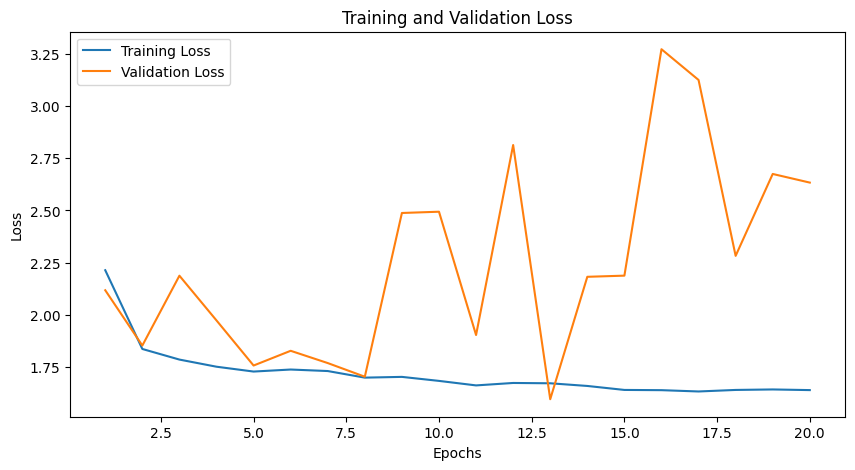

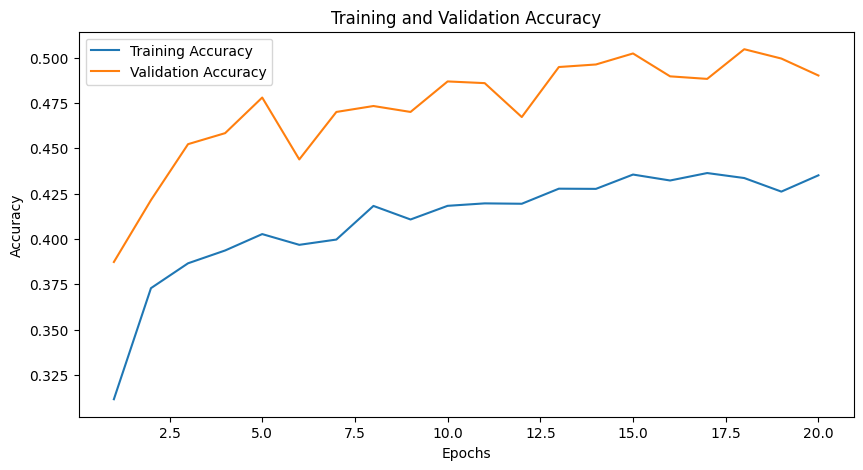

In [ ]:
# Plotting
epochs_range = range(1, epochs + 1)

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, h.history['loss'], label='Training Loss')
plt.plot(epochs_range, h.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, h.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, h.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

#### Testing
Try to improve the results provided in the Moodle competition wiki.

In [ ]:
import json

# Load database
json_file = 'xview_ann_test.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [ ]:
import numpy as np

anns = []
for json_img, json_ann in zip(json_data['images'].values(), json_data['annotations'].values()):
    image = GenericImage(json_img['filename'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = json_ann['category_id']
    image.add_object(obj)
    anns.append(image)

In [1]:
import numpy as np

# model.load_weights('model.hdf5', by_name=True)
y_true, y_pred = [], []
print(len(anns))
for ann in anns:
    # Load image
    image = load_geoimage(ann.filename)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        y_true.append(obj_pred.category)
        y_pred.append(pred_category)

NameError: name 'anns' is not defined

<ipython-input-7-39df9ea0fe34>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))


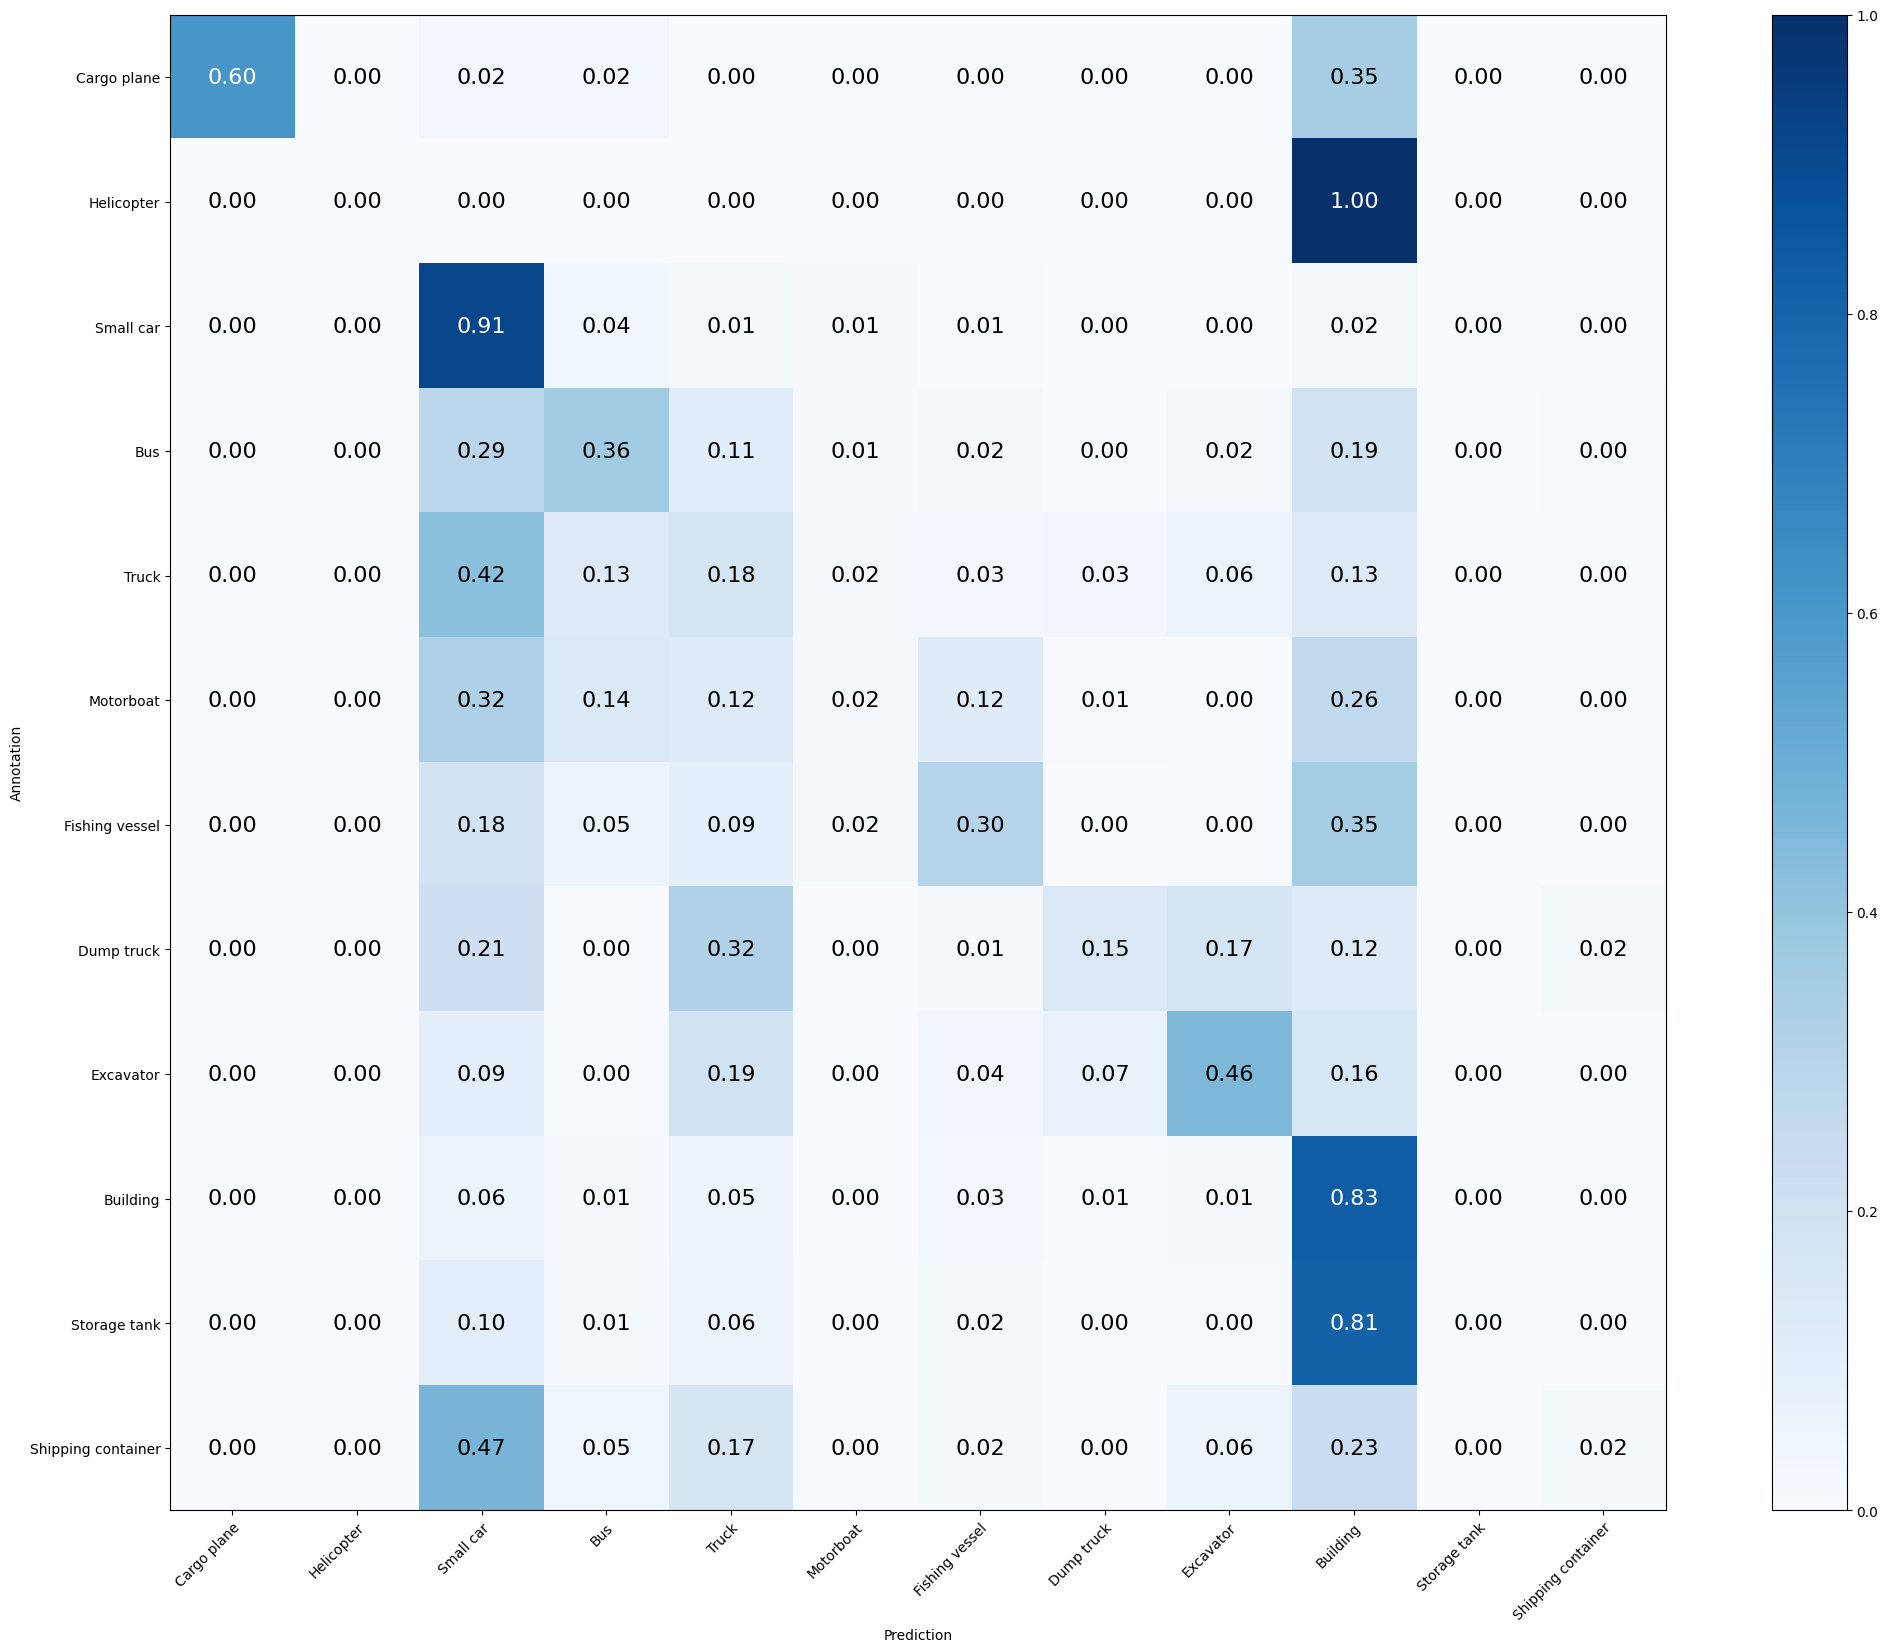

In [ ]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(categories.values()))
draw_confusion_matrix(cm, categories)

In [ ]:
import numpy as np

# Compute the accuracy
correct_samples_class = np.diag(cm).astype(float)
total_samples_class = np.sum(cm, axis=1).astype(float)
total_predicts_class = np.sum(cm, axis=0).astype(float)
print('Mean Accuracy: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
print('Mean Recall: %.3f%%' % (acc.mean() * 100))
acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
print('Mean Precision: %.3f%%' % (acc.mean() * 100))
for idx in range(len(categories)):
    # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
    # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
    tp = cm[idx, idx]
    fp = sum(cm[:, idx]) - tp
    fn = sum(cm[idx, :]) - tp
    tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
    # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
    recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
    # Precision: proportion of predicted positive cases that were truly real positives.
    precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
    # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
    specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
    # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
    # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
    f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
    print('> %s: Recall: %.3f%% Precision: %.3f%% Specificity: %.3f%% Dice: %.3f%%' % (list(categories.values())[idx], recall*100, precision*100, specificity*100, f1_score*100))

Mean Accuracy: 44.288%
Mean Recall: 31.885%
Mean Precision: 34.517%
> Cargo plane: Recall: 60.241% Precision: 94.340% Specificity: 99.882% Dice: 73.529%
> Helicopter: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Small car: Recall: 91.376% Precision: 49.063% Specificity: 78.492% Dice: 63.845%
> Bus: Recall: 36.364% Precision: 40.367% Specificity: 94.567% Dice: 38.261%
> Truck: Recall: 17.705% Precision: 22.041% Specificity: 91.803% Dice: 19.636%
> Motorboat: Recall: 2.284% Precision: 36.000% Specificity: 99.286% Dice: 4.296%
> Fishing vessel: Recall: 30.108% Precision: 24.779% Specificity: 96.656% Dice: 27.184%
> Dump truck: Recall: 14.754% Precision: 48.649% Specificity: 99.244% Dice: 22.642%
> Excavator: Recall: 45.614% Precision: 31.707% Specificity: 97.828% Dice: 37.410%
> Building: Recall: 82.657% Precision: 47.257% Specificity: 76.111% Dice: 60.134%
> Storage tank: Recall: 0.000% Precision: 0.000% Specificity: 99.916% Dice: 0.000%
> Shipping container: Rec

#### Report

You must prepare a report (PDF) describing:
* The problems and data sets (briefly).
* The process that you have followed to reach your solution for the “xview_recognition” benchmark, including your intermediate results. You must discuss and compare these results properly.
* Final network architectures, including optimization algorithms, regularization methods (dropout, data augmentation, etc.), number of layers/parameters, and performance obtained with your model on the train/valid/test data sets, including the plots of the evolution of losses and accuracy.
* It would also be very valuable your feedback on the use of “Cesvima” or “Google Colab" services.

In the submission via Moodle, attach your Python (.py) or Jupyter Notebook (.ipynb) source file, including in the report all results of computations attached to the code that generated them.

The assignment must be done in groups of 3 students.